In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import os

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures


# カテゴリ変数
実際のデータベースには，連続値だけでなくカテゴリ変数がある．  
たとえば，年齢は連続値だが，性別はカテゴリ変数である．  
ロジスティック回帰などを考えると，連続値と同じようにカテゴリ変数を扱うのは変である．  

そこで，カテゴリ変数を表現する方法として圧倒的によく用いられる手法がone-hot-encodingである．  
one-hot-encodingは性別として2つの種類があるとすると，2つの特徴量を追加し，1 or 0で表現する．  
one-hot-encodingのやり方は以下

In [6]:
adult_path = os.path.join(mglearn.datasets.DATA_PATH, "adult.data")
data = pd.read_csv(
    adult_path, header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])

data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]

display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


In [8]:
# 性別がどのような表記でされているかを確認
print(data.gender.value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


In [10]:
# カテゴリ変数をone-hot表現に変更

print("Original features:\n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("Features after get_dummies:\n", list(data_dummies.columns))

Original features:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

Features after get_dummies:
 ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-i

In [12]:
'''
つぎは，カテゴリ変数が文字ではなく数字で表現されている場合どうするか？ 
その場合は数字を文字列にする
'''


demo_df = pd.DataFrame({'Integer Feature': [0, 1, 2, 1],
                        'Categorical Feature': ['socks', 'fox', 'socks', 'box']})

demo_df['Integer Feature'] = demo_df['Integer Feature'].astype(str)
display(pd.get_dummies(demo_df, columns=['Integer Feature', 'Categorical Feature']))

,Integer Feature_0,Integer Feature_1,Integer Feature_2,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


# ビニング，離散化，線形モデル，決定木
データをどう表現するかは，利用する機械学習のモデルに依存する．  
線形モデルは1つしか特徴量が無い場合は1本の線になる．  
これをよりよくするには，ビニングや離散化という手法がある．  

### ビニング
ビニングは数値データをビンでわける．  
例えば，0から1，1から2，2から3・・・といった具合にわけ，その特徴量がどこに属しているかでone-hot表現にする．  
そうすることで，線形モデルでより柔軟に表現ができる．  

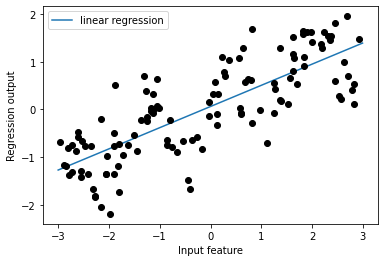

In [2]:
# ビニングする前のデータ
X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

In [8]:
# 10のビンを作るようにビニングする．
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

Text(0.5, 0, 'Input feature')

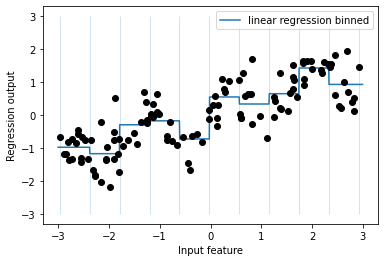

In [11]:
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

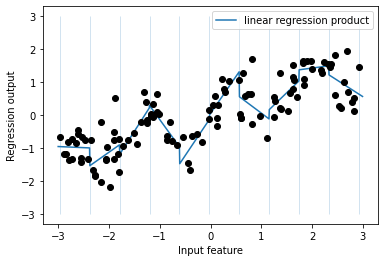

In [13]:
# 傾きがないので，傾きを追加する

X_product = np.hstack([X_binned, X * X_binned])

reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

### 特徴量の多項式
ビニングは連続値特徴量を拡張した．  
多項式も特徴量を拡張する方法の1つ

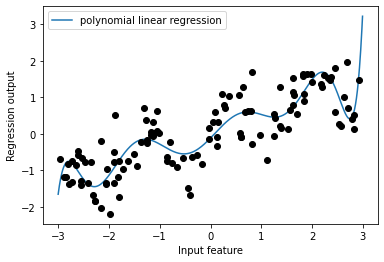

In [17]:
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

これは，SVMだと明示的にこのような変換をしなくても同様のふるまいをする．  
また，Ridgeなどの性能は，多項式をしよう